In [10]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import math

In [12]:
jpgs = ["imgs/" + jpg for jpg in os.listdir("imgs") if jpg.endswith('jpg')]
jpgs

['imgs/9405_cam_image_array_.jpg',
 'imgs/8057_cam_image_array_.jpg',
 'imgs/8023_cam_image_array_.jpg',
 'imgs/8003_cam_image_array_.jpg',
 'imgs/9411_cam_image_array_.jpg',
 'imgs/10292_cam_image_array_.jpg',
 'imgs/7992_cam_image_array_.jpg',
 'imgs/10210_cam_image_array_.jpg',
 'imgs/9441_cam_image_array_.jpg',
 'imgs/7998_cam_image_array_.jpg',
 'imgs/10217_cam_image_array_.jpg',
 'imgs/7989_cam_image_array_.jpg',
 'imgs/8012_cam_image_array_.jpg',
 'imgs/10203_cam_image_array_.jpg',
 'imgs/8064_cam_image_array_.jpg',
 'imgs/8053_cam_image_array_.jpg']

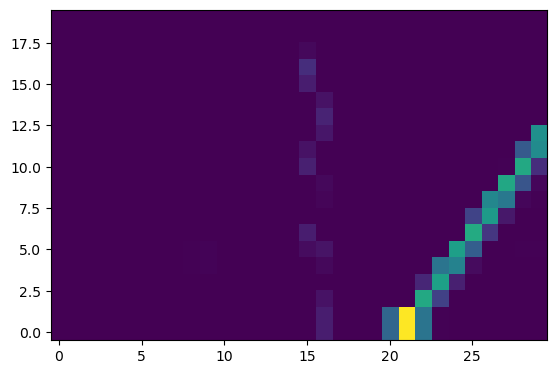

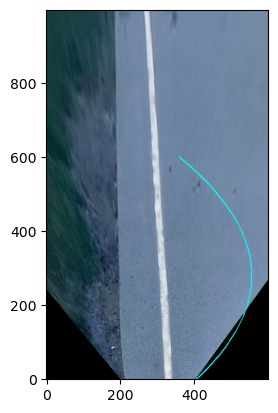

In [17]:
def relu(img, thresh):
    assert img.dtype == np.float64
    diff = img - thresh
    relud = (diff * (diff > 0))
    return relud + thresh

# read img
img = cv2.imread(jpgs[0])

# assume img is 1024 x 768
assert math.isclose(1024 / 768, img.shape[1] / img.shape[0], rel_tol=.1)

resize = img.shape[1] / 1024

# order: tr, tl, bl, br
src = [(650,370), (370,370), (0,700), (1000,730)]
src = [(int(resize*x), int(resize*y)) for (x,y) in src]
dst = [(10, 34), (-10, 34), (-10, 0), (10, 0)]
dst = [(int(10*(x + 30)), int(10*y)) for (x,y) in dst]

src_np = np.array(src, dtype=np.float32)
dst_np = np.array(dst, dtype=np.float32)

# colors = [
#     (0, 0, 255),  # green
#     (0, 255, 0),  # blue
#     (255, 0, 0),  # red
#     (255, 255, 0),  # yellow
# ]
# for cnr_idx, (x, y) in enumerate(src):
#     cv2.circle(img, (x, y), 10, colors[cnr_idx], -1)

# inverse projective map
M = cv2.getPerspectiveTransform(src_np, dst_np)
warped_viz = cv2.warpPerspective(img, M, (600, 1000), flags=cv2.INTER_LINEAR)
warped = cv2.warpPerspective(img, M, (600, 1000), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

# threshold in yuv space
yuv = cv2.cvtColor(warped, cv2.COLOR_BGR2YUV)
yuv = yuv[:,:,0] / 255.0
yuv = relu(yuv, .7)

# resize image to (30,50), then crop to (30,20)
resized = cv2.resize(yuv, (30,50), interpolation = cv2.INTER_AREA)
resized = resized[:20,:]

# tophat convolve
tophat = np.array([-1, -1, 2, 2, -1, -1])
conv = cv2.filter2D(src=resized, ddepth=-1, kernel=tophat)

# relu out negative response from kernel
relud = relu(conv, 0)

# fit a quadratic
flattened = relud.reshape(-1)
indices = list(np.ndindex(relud.shape[:]))
pts = np.c_[indices, flattened]

coeffs = np.polyfit(x=pts[:,0],y=pts[:,1],w=pts[:,2], deg=2)
poly = np.poly1d(coeffs)

yp = np.linspace(0,30,100) # 100 pts between (0,30)
xp = poly(yp)

xp = 20 * xp
yp = 20 * yp

curve = np.column_stack((xp.astype(np.int32), yp.astype(np.int32)))
cv2.polylines(warped_viz, [curve], False, (0,255,255), thickness=2)

# compute curvilinear position and curvature at 0
# self.offset = poly(0)
a,b,c = coeffs
# self.curv = (1 + b ** 2) ** 1.5 / abs(2*a)

plt.imshow(relud, origin='lower')
plt.show()
plt.imshow(warped_viz, origin='lower')
plt.show()

# cv2.flip(warped_viz, 0)